In [67]:
import string
import re
from functools import reduce

import sqlite3
import pandas as pd
import numpy as np
import nltk
from toolz.functoolz import pipe
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_columns", 9999)

# TODO: 
# topic models
# other nlp stuff like parse trees, tfidf + cosine scores, cluster on tfidf vectors, etc
# word embeddings?
# semantic analysis, what is said about different persons/countries
# analyze the graph of from who to who emails are sent and so on

In [2]:
# Establish a database connection
db_conn = sqlite3.connect("/home/john/datasets/hillary-emails/database.sqlite")
db = db_conn.cursor()
pd_sql = lambda query, params=None: pd.read_sql_query(query, params=params, con=db_conn)

First let's see how the database is structured.

In [3]:
tables = pd_sql("SELECT tbl_name FROM sqlite_master WHERE type='table'")
display(tables)

for _, t in tables.iterrows():
    display(t.tbl_name)
    t_info = pd_sql("PRAGMA table_info({})".format(t.tbl_name))
    display(pd.DataFrame(columns=t_info["name"]))

,tbl_name
0,Emails
1,Persons
2,Aliases
3,EmailReceivers


'Emails'

name,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText


'Persons'

name,Id,Name


'Aliases'

name,Id,Alias,PersonId


'EmailReceivers'

name,Id,EmailId,PersonId


## Email body texts
Let's start the exploration by looking at the email bodies.

In [3]:
email_bodies = pd_sql("SELECT ExtractedBodyText FROM Emails WHERE ExtractedBodyText != ''")
display(email_bodies.sample(10))
email_bodies = pd.Series(email_bodies.ExtractedBodyText)

,ExtractedBodyText
6364,I just went over edits w Dan. Let me know if t...
5363,202 647 8947
3961,Fyi
4523,Ordering now.
206,B6\nB5\nU.S. Department of State\nCase No. F-2...
1996,Fyi
4713,I just wanted to make sure you know that the C...
1619,"Mills, Cheryl D <MillsCD@state.gov>\nSaturday,..."
2754,There are 2 draft letters from mara being faxe...
2726,Checking\nI am sure they will\nMitchell just r...


## Email lengths

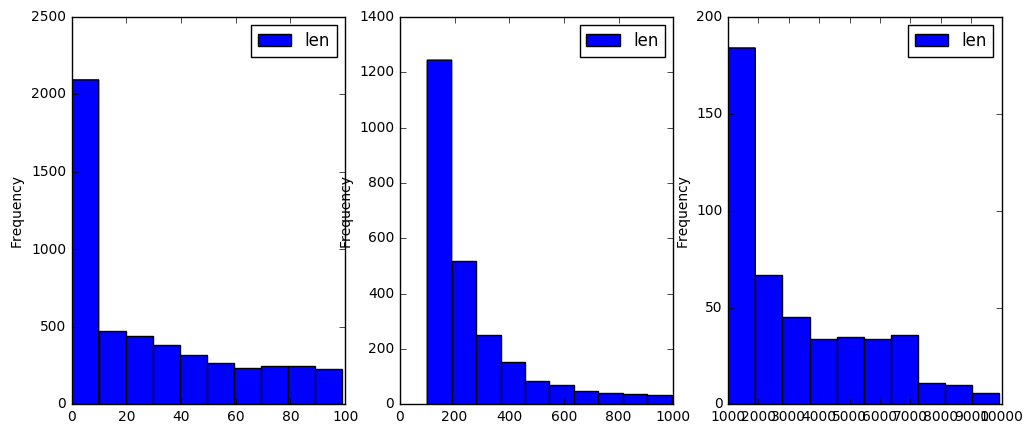

In [170]:
email_body_lengths = pd_sql("SELECT length(ExtractedBodyText) as len FROM Emails")

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
condition = lambda above, below: (above <= email_body_lengths.len) & (email_body_lengths.len < below)
email_body_lengths.loc[condition(0, 100)].plot.hist(bins=10, ax=ax1)
email_body_lengths.loc[condition(100, 1000)].plot.hist(bins=10, ax=ax2)
email_body_lengths.loc[condition(1000, 10000)].plot.hist(bins=10, ax=ax3)

# TODO pie chart with groups of lengths instead

## Data cleaning

In [96]:
nltk.download("punkt")
nltk.download("stopwords")

tokens_to_remove = list(string.punctuation) + stopwords.words("english") + ["—", "•", "--", "``", "\"", "''"]

time_regex = re.compile("([01]?[0-9]|2[0-3]):([0-5][0-9]) ?(pm|am)")
def transform_time(tokens):
    """Transforms a string that can be interpreted as a time stamp into <time>.
    Leaves rest unchanged"""
    return re.sub(time_regex, "<time>", " ".join(tokens)).split()

# TODO: maybe not useful?
def transform_date(tokens):
    """Transforms a string that can be interpreted as a date into <date>.
    Leaves rest unchanged"""
    return tokens

transform_pipeline = lambda email_body: pipe(email_body,
                                   lambda s: s.lower(),
                                   nltk.word_tokenize,
                                   lambda tokens: list(filter(lambda s: s not in tokens_to_remove, tokens)),
                                   transform_time,
                                   transform_date)

email_bodies_cleaned = email_bodies.apply(transform_pipeline)

[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic modeling
Topic models are statistical models that try to find structure in text corpuses by finding "topics". A topic defines a distribution over the vocabulary of the whole corpus. Each document can then be described by a distribution over topics. We can use this to get a lower dimensional representation of each document which can then be used to find documents that might be similar to each other in tasks like clustering or classification.


In [97]:
# Remove short documents
DOC_LEN_LIMIT = 30
documents = email_bodies_cleaned[email_bodies_cleaned.apply(len) >= DOC_LEN_LIMIT]
print("Num documents of length above {}: {}".format(DOC_LEN_LIMIT, documents.shape[0]))

# TODO: remove high frequency words?

# Prepare the corpus
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

Num documents of length above 30: 1225


In [98]:
# Fit an LDA model
NUM_TOPICS = 10
lda = LdaModel(corpus, num_topics=NUM_TOPICS)

In [99]:
top_word_idxs_prob = [lda.get_topic_terms(k, topn=50) for k in range(NUM_TOPICS)]
top_word_probs = [[(dictionary[word_idx], prob) for word_idx, prob in doc] for doc in top_word_idxs_prob]

top_words = reduce(lambda df, top_words: pd.concat((df, pd.DataFrame(wp[0] for wp in top_words)), axis=1), 
                   top_word_probs,
                   None)
top_words.columns = ["Topic {}".format(k) for k in range(NUM_TOPICS)]

display(top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,'s,'s,'s,'s,'s,'s,'s,'s,'s,'s
1,<time>,state,state,obama,<time>,would,<time>,would,<time>,state
2,secretary,president,would,would,office,n't,secretary,obama,state,<time>
3,said,would,house,president,state,said,office,said,said,secretary
4,obama,new,u.s.,n't,secretary,obama,state,n't,secretary,office
5,would,n't,obama,state,new,us,room,one,new,one
6,state,house,department,also,department,president,would,president,office,obama
7,n't,obama,said,one,meeting,house,meeting,people,n't,president
8,office,clinton,n't,u.s.,room,state,u.s.,<time>,president,clinton
9,time,one,one,said,one,also,department,state,would,department


It's possible that many of the email bodies used here are too short to work well with standard LDA.